In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Adding a constant variable 
import statsmodels.api as sm  
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np

# import standardscalar
from sklearn.preprocessing import StandardScaler
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')


In [2]:
##Block to define common function used through out

def univariate(df,col):
        sns.set(style="darkgrid")
        fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(10,3))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[1])
        plt.show()
        
# function to generate plots related to Categorical Variables
def categorical_plot(col,x,y):
    plt.figure(figsize = (x,y))
    plt.subplot(1,2,1)
    sns.barplot(col,'cnt',data=df)
    #plt.subplot(1,2,2)
   # sns.barplot(col,'cnt',data=df, hue='yr',palette='Paired')
    #plt.legend(labels=['2018', '2019'])
    return

# function to calculate VIF
def calulateVIF(X_train_new):
    vif = pd.DataFrame()
    X = X_train_new
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif
        
# function to getStats model
def getStatModel(X_train_rfe,ytrain):
    X_train_rfe = sm.add_constant(X_train_rfe)
    lm = sm.OLS(ytrain,X_train_rfe).fit()   # Running the linear model
    return lm

# function to getStats model summary
def getStatModelSummary(X_train_rfe,ytrain):
    lm = getStatModel(X_train_rfe,ytrain)
    return lm.summary()

# Method to get null count

def getnullcount(dataframe):
    return dataframe.isnull().sum()

def getnullgreaterthanpercentage(dataframe,perct):
    null_count=round(100*(getnullcount(dataframe)/len(dataframe.index)),2)
    null_count=null_count[null_count>=perct]
    return null_count
    
# Method to get Meta-Data about any dataframe passed 
def retrievemetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes, # data types of columns
                    'Total_Element': dataframe.count(), # total elements in columns
                    'Null_Count': dataframe.isnull().sum(), # total null values in columns
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100 # percentage of null values,
                       })
    return metadata_matrix

In [3]:
#import train.csv file
df = pd.read_csv('train.csv')

## Steps:

1 Checking Data and its attribuites, shape

2 Data Cleaning and manipulation

3 Perform Basic EDA

4 Splitting the dataset

5 Model Building and Evaluation

6 Apply Ridge and Lasso Regression

7 Conclusion

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Checking the shape of the dataframe 
df.shape

(1460, 81)

STEP 1: Data Cleaning

In [6]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
pd.isnull(df).sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [8]:
# How many types of each data type column exists
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

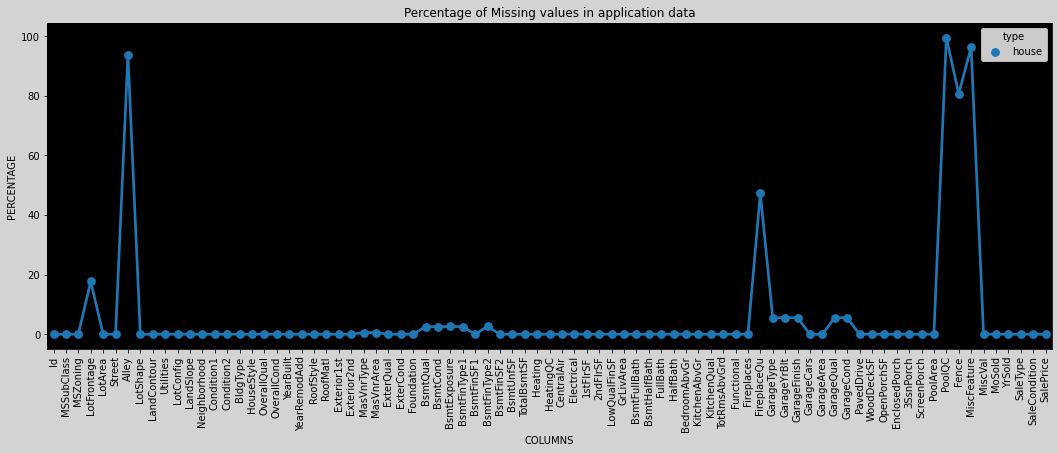

In [9]:
#Let's view the Null percentages in graph so that things become more clear

fig = plt.figure(figsize=(18,6))

miss_appdata = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
miss_appdata["type"] = "house"


ax = sns.pointplot("index",0,data=miss_appdata,hue="type")
plt.xticks(rotation =90,fontsize =10)
plt.title("Percentage of Missing values in application data")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
ax.set_facecolor("k")
fig.set_facecolor("lightgrey")

In [10]:
#let's check the Columns with high missing percentage >=30% (30%  value I came to after looking up  null percentage)
null_count=getnullgreaterthanpercentage(df,30)
print(null_count)

Alley          93.77
FireplaceQu    47.26
PoolQC         99.52
Fence          80.75
MiscFeature    96.30
dtype: float64


## 2. Data Cleaning and manipulation


### 2a Remove columns that are  null > 80%


In [11]:
cols_dropped=([null_count[null_count >=80.00].index])
df.drop(labels=cols_dropped[0],axis=1,inplace=True)

In [12]:
#let's check the Columns with high missing percentage >=30% (30%  value I came to after looking up  null percentage)
null_count=getnullgreaterthanpercentage(df,30)
print(null_count)

FireplaceQu    47.26
dtype: float64


In [13]:
print(df.FireplaceQu.unique())
print(df.MasVnrType.unique())
print(df.BsmtQual.unique())
print(df.BsmtCond.unique())
print(df.BsmtCond.unique())
print(df.BsmtFinType1.unique())
print(df.BsmtFinType2.unique())
print(df.GarageType.unique())
print(df.GarageFinish.unique())
print(df.GarageQual.unique())
print(df.GarageCond.unique())
print(df.BsmtExposure.unique())
print(df.Electrical.unique())
     

[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
['Gd' 'TA' 'Ex' nan 'Fa']
['TA' 'Gd' nan 'Fa' 'Po']
['TA' 'Gd' nan 'Fa' 'Po']
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
['RFn' 'Unf' 'Fin' nan]
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
['No' 'Gd' 'Mn' 'Av' nan]
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]


In [14]:

# impute categorical variables with 'None' ,as these are dipctiong null values
null_with_meaning = ["MasVnrType", "BsmtQual", "BsmtCond", "BsmtCond", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond","BsmtExposure","Electrical"]
for i in null_with_meaning:
    df[i].fillna("none", inplace=True)

In [15]:
#let's check the Columns with high missing percentage >=30% (30%  value I came to after looking up  null percentage)
null_count=getnullgreaterthanpercentage(df,1)
print(null_count)
val = df["LotFrontage"].mean(skipna=True)
print(val)

LotFrontage    17.74
GarageYrBlt     5.55
dtype: float64
70.04995836802665


In [16]:
#Treating numerical variables for null values

val = df["LotFrontage"].mean(skipna=True)
df["LotFrontage"].fillna(val, inplace=True)
df["GarageYrBlt"].fillna(df["GarageYrBlt"].median(), inplace=True)
df["MasVnrArea"].fillna(df["MasVnrArea"].median(), inplace=True)


In [17]:
df["LotFrontage"]

0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1460, dtype: float64

In [18]:
#df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
#let's check the Columns with high missing percentage >=30% (30%  value I came to after looking up  null percentage)
null_count=getnullgreaterthanpercentage(df,1)
print(null_count)

Series([], dtype: float64)


In [20]:
  
null_count=getnullgreaterthanpercentage(df,30)
print(null_count)

Series([], dtype: float64)


### 2b Remove unnecessary columns

In [21]:
# Dropping ID Column
df = df.drop(['Id'], axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


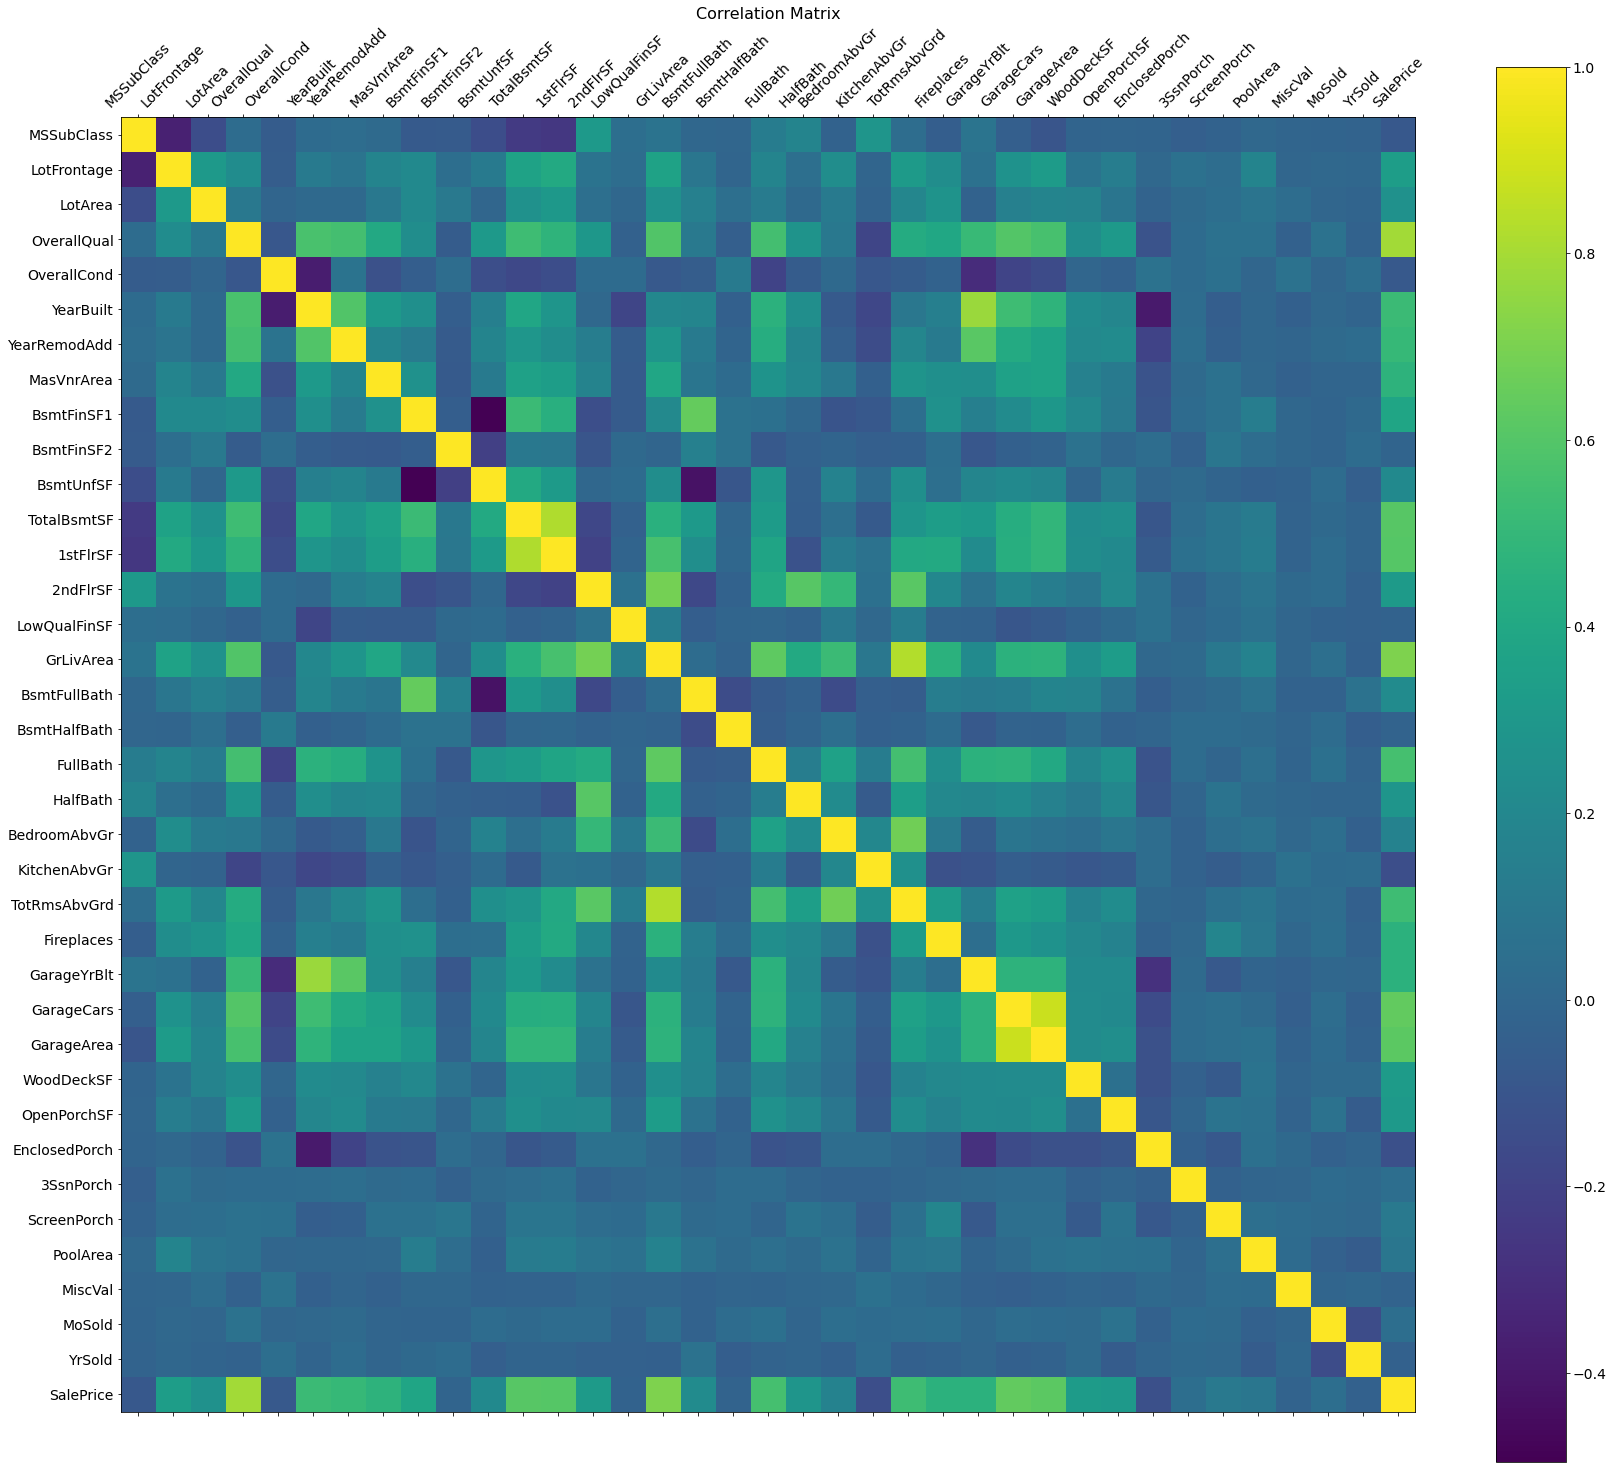

In [22]:
#Check corelation between variables to remove some of corelated columns to remove bias 
f = plt.figure(figsize=(29, 25))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
#plt.matshow(loan.corr())
#plt.show()

## Observation: From above corelation matrix we can drop highly correlated variables like GarageCars, GarageArea so let's proceed further

In [23]:
# Dropping GarageCars Column
df = df.drop(['GarageCars','TotalBsmtSF'], axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


## STEP3: Perform Basic EDA

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'CollgCr'),
  Text(1, 0, 'Veenker'),
  Text(2, 0, 'Crawfor'),
  Text(3, 0, 'NoRidge'),
  Text(4, 0, 'Mitchel'),
  Text(5, 0, 'Somerst'),
  Text(6, 0, 'NWAmes'),
  Text(7, 0, 'OldTown'),
  Text(8, 0, 'BrkSide'),
  Text(9, 0, 'Sawyer'),
  Text(10, 0, 'NridgHt'),
  Text(11, 0, 'NAmes'),
  Text(12, 0, 'SawyerW'),
  Text(13, 0, 'IDOTRR'),
  Text(14, 0, 'MeadowV'),
  Text(15, 0, 'Edwards'),
  Text(16, 0, 'Timber'),
  Text(17, 0, 'Gilbert'),
  Text(18, 0, 'StoneBr'),
  Text(19, 0, 'ClearCr'),
  Text(20, 0, 'NPkVill'),
  Text(21, 0, 'Blmngtn'),
  Text(22, 0, 'BrDale'),
  Text(23, 0, 'SWISU'),
  Text(24, 0, 'Blueste')])

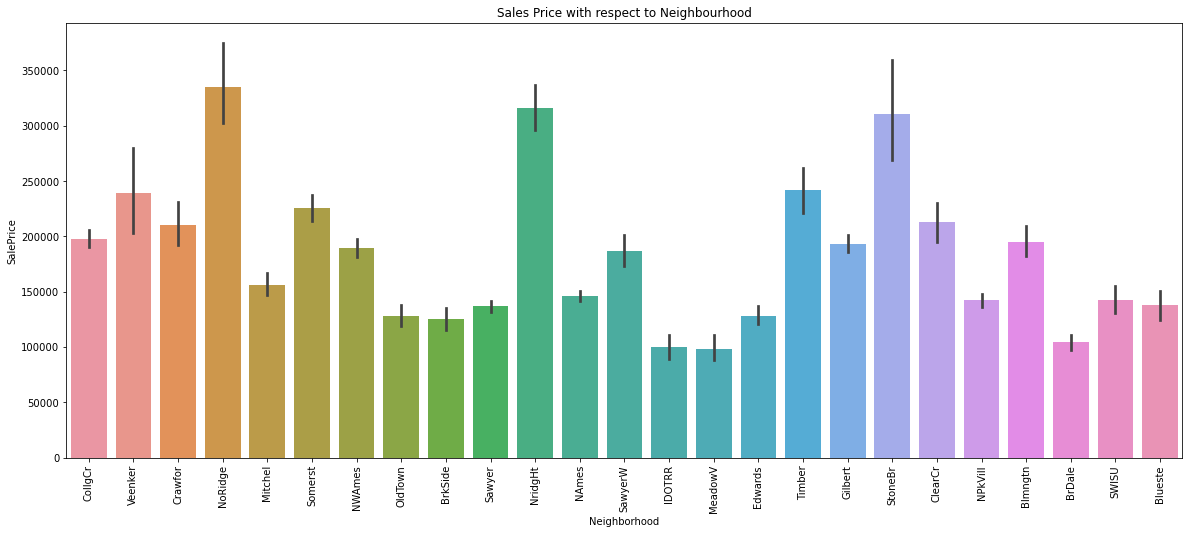

In [24]:
# plot 'Sale Price' with respect to 'Neighborhood'

plt.figure(figsize=(20, 8))
sns.barplot(x="Neighborhood", y="SalePrice", data= df)
plt.title("Sales Price with respect to Neighbourhood")
plt.xticks(rotation=90)

### Observation:Increase in the overall quality has a direct positive effect on the sale price

### Plot the distribution plot for SalesPrice

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

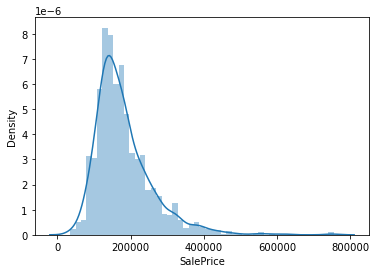

In [25]:
sns.distplot(df['SalePrice'])

### Observation: We can see distribution of Salesprice is left skewed so in order to correct this we can use log functions

In [26]:
#Log Transformation
df['SalePrice']=np.log1p(df['SalePrice'])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

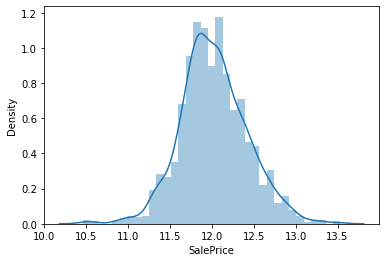

In [27]:
sns.distplot(df['SalePrice'])

### Observation: After applying log transformation graph is Centralized

## let's plot scatter plot to see how graph of independent varibales relates to dependent variable

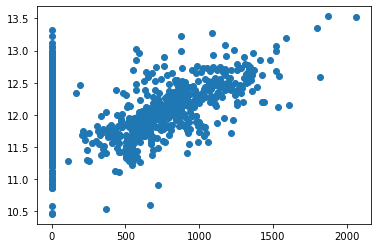

In [28]:
plt.scatter( x = df['2ndFlrSF'], y = df['SalePrice'])
plt.show()

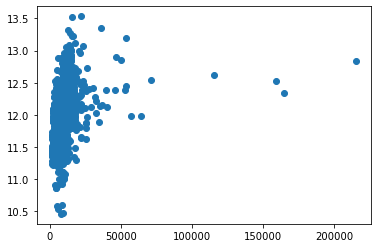

In [29]:

plt.scatter( x = df['LotArea'], y = df['SalePrice'])
plt.show()

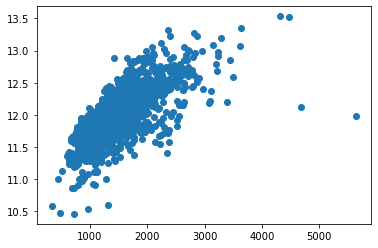

In [30]:

plt.scatter( x = df['GrLivArea'], y = df['SalePrice'])
plt.show()

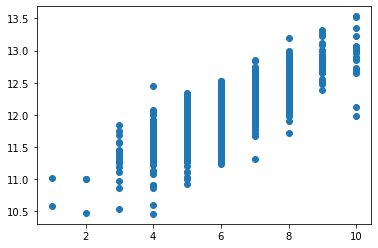

In [31]:

plt.scatter( x = df['OverallQual'], y = df['SalePrice'])
plt.show()

### Observartion: Clearly many of the variables are not showing linear graph with independent variables

### Observation:Properties in some of the Neighborhoods like NoRidge,NridgHt,StoneBr are high priced.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10')])

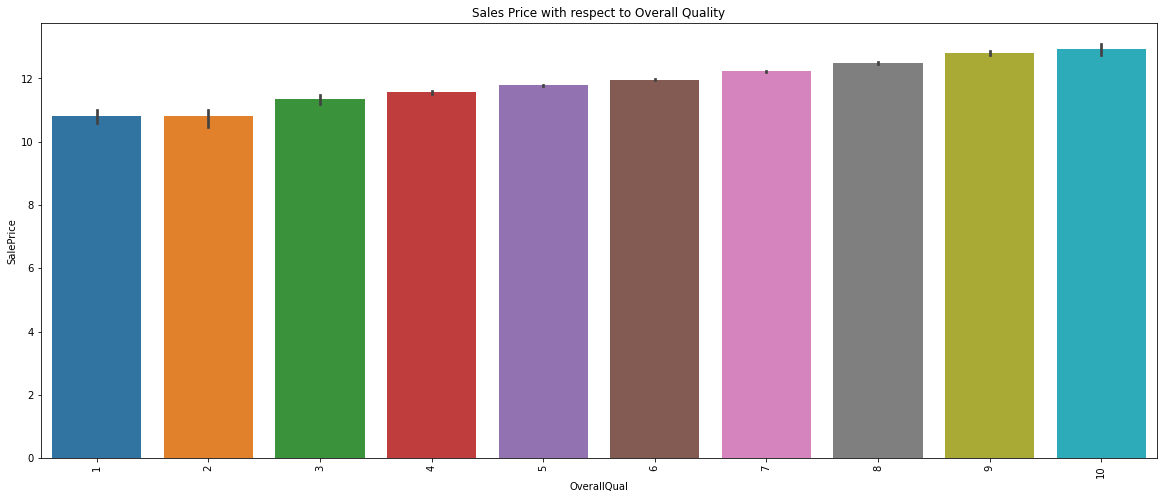

In [32]:
# plot 'overall quality' with respect to 'Saleprice'

plt.figure(figsize=(20, 8))
sns.barplot(x="OverallQual", y="SalePrice", data= df)
plt.title("Sales Price with respect to Overall Quality")
plt.xticks(rotation=90)

## Observation: Sales price increases with overall Quality

In [33]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,12.429220


### Create dummies 

In [34]:
#Get Unique variables for Dummy variables creation
print(df["Street"].unique())

['Pave' 'Grvl']


In [35]:
print(df["LotShape"].unique())

['Reg' 'IR1' 'IR2' 'IR3']


In [36]:
print(df["MSZoning"].unique())

['RL' 'RM' 'C (all)' 'FV' 'RH']


In [37]:
print(df["LandSlope"].unique())

['Gtl' 'Mod' 'Sev']


In [38]:
print(df["LandContour"].unique())

['Lvl' 'Bnk' 'Low' 'HLS']


In [39]:
print(df["Utilities"].unique())

['AllPub' 'NoSeWa']


In [40]:
print(df["LotConfig"].unique())

['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


In [41]:
print(df["Neighborhood"].unique())

['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


In [42]:
# Get the dummy variables for the feature weathersit' and store it in a new variable - 'status'
#df=pd.get_dummies(data=df, columns=['Street', 'LotShape','MSZoning','LandContour','Utilities','LotConfig','LandSlope','Neighborhood'], drop_first = True)
df=pd.get_dummies(df,drop_first=True)
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


## STEP4: Splitting the dataset

In [43]:
X = df.drop(['SalePrice'], axis=1)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,1,0,0,0,1,0


In [44]:
# Putting response variable to y
y = df['SalePrice']
y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [45]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

## Standardize values for further analysis

In [46]:
# columns to be scaled
X_train.select_dtypes(include=['int64','int32','float64','float32']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [47]:
num_vars= ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
           'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',  
           '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
           'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageArea',
           'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold', 'YrSold']
X_train[num_vars].head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,YrSold
210,30,5604,5,6,1925,1950,0.0,468,0,396,...,5,0,1980.0,0,0,0,96,0,4,2008
318,60,9900,7,5,1993,1993,256.0,987,0,360,...,9,1,1993.0,656,340,60,144,0,4,2009
239,50,8741,6,4,1945,1950,0.0,94,0,641,...,7,1,1949.0,220,0,140,0,0,4,2010
986,50,5310,6,8,1910,2003,0.0,0,0,485,...,5,0,1950.0,255,394,0,0,0,6,2006
1416,190,11340,4,6,1885,1950,0.0,0,0,777,...,11,0,1971.0,560,0,0,114,0,4,2010


In [48]:
#Scaling using MinMax
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#scaler = StandardScaler()
scaler=MinMaxScaler()

In [49]:
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [50]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,0.058824,67.0,0.019306,0.444444,0.625,0.384058,0.000000,0.00,0.082920,0.0,...,0,0,0,0,1,0,0,0,1,0
318,0.235294,90.0,0.039403,0.666667,0.500,0.876812,0.716667,0.16,0.174876,0.0,...,0,0,0,0,1,0,0,0,1,0
239,0.176471,52.0,0.033981,0.555556,0.375,0.528986,0.000000,0.00,0.016655,0.0,...,0,0,0,0,1,0,0,0,1,0
986,0.176471,59.0,0.017931,0.555556,0.875,0.275362,0.883333,0.00,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0
1416,1.000000,60.0,0.046139,0.333333,0.625,0.094203,0.000000,0.00,0.000000,0.0,...,0,0,0,0,1,0,0,0,1,0


## Step5 :Model Building and Evaluation

In [51]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [52]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 25)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [53]:
#Find the top features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 99),
 ('LotFrontage', False, 215),
 ('LotArea', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', False, 46),
 ('MasVnrArea', False, 214),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', False, 6),
 ('BsmtUnfSF', False, 5),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', False, 2),
 ('LowQualFinSF', False, 30),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 50),
 ('BsmtHalfBath', False, 201),
 ('FullBath', False, 171),
 ('HalfBath', False, 173),
 ('BedroomAbvGr', False, 105),
 ('KitchenAbvGr', True, 1),
 ('TotRmsAbvGrd', False, 190),
 ('Fireplaces', False, 193),
 ('GarageYrBlt', False, 198),
 ('GarageArea', True, 1),
 ('WoodDeckSF', False, 51),
 ('OpenPorchSF', False, 119),
 ('EnclosedPorch', False, 92),
 ('3SsnPorch', False, 216),
 ('ScreenPorch', False, 87),
 ('PoolArea', False, 217),
 ('MiscVal', False, 218),
 ('MoSold', False, 211),
 ('YrSold', False, 169),
 ('MSZoning_FV', True, 1),
 ('MSZoning_RH', True, 1),
 ('MS

In [54]:
col = X_train.columns[rfe.support_]
col
# Extract the top features

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1',
       '1stFlrSF', 'GrLivArea', 'KitchenAbvGr', 'GarageArea', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Condition2_PosN',
       'Condition2_RRAe', 'RoofStyle_Shed', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Exterior1st_BrkComm', 'Functional_Sev'],
      dtype='object')

In [55]:
#Check the shape of train and test
X_train1=X_train[col]
X_test1=X_test[col]
print(X_train1.shape)
print(X_test1.shape)
print(y_train.shape)
print(y_test.shape)

(1021, 25)
(438, 25)
(1021,)
(438,)


In [56]:
lm1=lm.fit(X_train, y_train)

In [57]:
# Print the coefficients and intercept
print(lm1.intercept_)
print(lm1.coef_)

6.965795467141612
[-4.75998888e-02  3.50202293e-04  6.91666400e-01  3.55467929e-01
  2.87415101e-01  2.84630588e-01  7.27680320e-02  3.76598960e-03
  1.05623105e+00  2.46709993e-01  3.04441039e-01  5.97546278e-01
  2.80690164e-01 -3.36233877e-03  6.07089452e-01  6.60175349e-02
  3.61097180e-03  2.25453937e-02  1.55029532e-02  7.84287996e-02
 -1.18040601e-01  1.26690476e-02 -8.66652996e-03  2.28081629e-03
  2.12001432e-01  7.31507472e-02  2.75515062e-02  4.99834735e-02
  1.19722893e-04  5.42636435e-02  7.86800852e-05  1.48056440e-06
  2.30927882e-03 -1.29552188e-02  4.43555704e-01  4.35200199e-01
  4.32541921e-01  3.82895560e-01  8.34255632e-02  1.56996350e-02
 -6.31793382e-03  6.04608499e-03  5.98998779e-03 -9.89119738e-03
  2.25951067e-02 -6.65543862e-02  3.17155696e-02 -3.55486515e-02
 -1.52216945e-02 -5.94484131e-03  2.39270366e-02 -2.20485037e-01
  5.29312229e-02 -3.65177212e-02  8.71514990e-02  6.68333350e-02
  1.11202684e-02  1.70707884e-01 -2.59110236e-02  1.84528446e-02
  4.337

In [58]:
#import libraries for model evalution
from sklearn.metrics import r2_score, mean_squared_error

In [59]:
#r2score,RSS and RMSE
y_pred_train = rfe.predict(X_train)
y_pred_test = rfe.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Trainset -",r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Testset -",r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS trainset -" ,rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS testset -" ,rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE trainset -" ,mse_train_lr)
metric.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE testset -" ,mse_test_lr)
metric.append(mse_test_lr)

rmse_train_lr =np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE trainset -" ,rmse_train_lr)
metric.append(rmse_train_lr)

rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE testset -" ,rmse_test_lr)
metric.append(rmse_test_lr)


R2 Trainset - 0.9111626986910345
R2 Testset - 0.8334106869606123
RSS trainset - 14.257514787541346
RSS testset - 12.005693287990958
MSE trainset - 0.0139642652179641
MSE testset - 0.027410258648381182
RMSE trainset - 0.11817049216265497
RMSE testset - 0.1655604380532414


### Observations: R2 of test data set has reduced considerably in test dataset, also very high value of RMSE needs to be investigated

In [60]:
# Creating a dataframe for the coefficients obtained from Lasso
cols = X.columns
cols = cols.insert(0, "constant")
model_parameters = list(lm1.coef_ )
model_parameters.insert(0, lm1.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
mod = list(zip(cols, model_parameters))
para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']
para.head(500)

,Variable,Coeff
0,constant,6.966
1,MSSubClass,-0.048
2,LotFrontage,0.000
3,LotArea,0.692
4,OverallQual,0.355
...,...,...
242,SaleCondition_AdjLand,0.112
243,SaleCondition_Alloca,0.106
244,SaleCondition_Family,0.033
245,SaleCondition_Normal,0.048


## Step6: Apply Ridge and Lasso Regression

### Ridge

In [61]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

### Using Cross-validation technique to tune up the hyperparameter value

In [62]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [63]:
print(ridge_model_cv.best_params_)
print(ridge_model_cv.best_score_)

{'alpha': 0.01}
-0.09206058783191944


## Optimum value of alpha is 0.01


In [64]:
alpha = 0.01
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)
print(ridge.coef_)
print((ridge.coef_).shape)

[-5.28331870e-02  2.32294030e-04  6.42949207e-01  3.67757227e-01
  2.73249882e-01  2.57043740e-01  7.24348444e-02  3.65746231e-03
  8.51672515e-01  2.02484651e-01  2.53351305e-01  5.96055499e-01
  2.72106422e-01  5.73486986e-03  6.03346075e-01  7.87685788e-02
  9.28587815e-03  3.40230027e-02  1.90617070e-02  9.26192663e-02
 -1.08577563e-01  1.97591143e-02 -1.30476433e-02 -4.37625590e-03
  2.12263727e-01  7.22455579e-02  2.51700309e-02  5.32275829e-02
  1.36450507e-04  5.61139534e-02 -5.94601752e-06  9.40664188e-07
  2.75071408e-03 -1.37163392e-02  4.41230645e-01  4.34715423e-01
  4.33240479e-01  3.86768795e-01  7.62697676e-02  1.55681024e-02
 -2.57545477e-02  6.13730239e-03  1.37091605e-02  5.76612023e-03
  3.06829954e-02 -8.99818016e-02  3.31913348e-02 -3.84704394e-02
 -2.48643956e-02 -7.20231291e-03  2.44061480e-02 -1.89615736e-01
  3.80864534e-02 -4.05243518e-02  7.79787244e-02  6.89548558e-02
  1.22028602e-02  1.70411696e-01 -3.33302981e-02  1.96435980e-02
  3.17029449e-02 -1.53693

## Observation: With Ridge coefficients changed and reduced but no. of coefficients remained same.

In [65]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Trainset -",r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Testset -",r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS trainset -" ,rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS testset -" ,rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE trainset -" ,mse_train_lr)
metric2.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE testset -" ,mse_test_lr)
metric2.append(mse_test_lr)

rmse_train_lr =np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE trainset -" ,rmse_train_lr)
metric2.append(rmse_train_lr)

rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE testset -" ,rmse_test_lr)
metric2.append(rmse_test_lr)



R2 Trainset - 0.9577972334360926
R2 Testset - 0.8680429867008874
RSS trainset - 6.773129749488933
RSS testset - 9.509826290561143
MSE trainset - 0.006633819539166438
MSE testset - 0.021711932170230923
RMSE trainset - 0.08144826295978594
RMSE testset - 0.14734969348536467


## Observation: Now R2 has improved on test and train set as compared to normal linear regression which is good but RMSE still doesn't look in control

In [66]:
# Creating a dataframe for the coefficients obtained from ridge

cols = X_train.columns
cols.insert(0,'constant')
model_parameters = list(ridge.coef_ )
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
mod = list(zip(cols, model_parameters))
para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']
#para.head(300)

# Significant variables which predict price of house when used ridge
para.sort_values(by = 'Coeff',ascending = False).head(10)
# Chose variables whose coefficients are non-zero
#pred = pd.DataFrame(para[(para['Coeff'] != 0)])

#print("Shape -", pred.shape)

,Variable,Coeff
0,MSSubClass,7.588
109,RoofMatl_Metal,2.746
110,RoofMatl_Roll,2.597
111,RoofMatl_Tar&Grv,2.552
114,Exterior1st_AsphShn,2.534
112,RoofMatl_WdShake,2.489
108,RoofMatl_Membran,2.479
113,RoofMatl_WdShngl,2.348
9,BsmtFinSF2,0.852
3,OverallQual,0.643


In [67]:
# Chose variables whose coefficients are non-zero
pred = pd.DataFrame(para[(para['Coeff'] != 0)])
pred
# These 16 variables obtained from Lasso Regression can be concluded to have the strong effect on the SalePrice
pred.shape

(234, 2)

### Lasso

### Using Cross-validation technique to tune up the hyperparameter value

In [68]:
lasso = Lasso()

# cross validation
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [69]:
print(lasso_model_cv.best_params_)
print(lasso_model_cv.best_score_)

{'alpha': 0.0001}
-0.08914543933024069


## Optimum value of alpha is 0.0001

In [70]:
alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [71]:
print(lasso.coef_)
print((lasso.coef_).shape)

[-9.01782560e-02 -0.00000000e+00  2.81522475e-01  4.25821585e-01
  2.50200023e-01  1.67884419e-01  7.36029233e-02  0.00000000e+00
  1.71483307e-01  4.92009538e-02  6.36105663e-02  9.19851494e-02
  0.00000000e+00 -2.07996347e-02  1.24164343e+00  1.27664966e-01
  5.49615323e-03  6.68613887e-02  2.81422222e-02  7.93731903e-02
 -5.71008244e-02  4.32808141e-02 -0.00000000e+00 -2.39281702e-03
  2.03641758e-01  6.76323038e-02  2.63775313e-02  3.94418254e-02
  1.84048923e-04  4.93800281e-02 -2.71053831e-04 -3.81218373e-06
 -2.45180059e-03 -1.43598179e-02  3.29406266e-01  3.32734087e-01
  3.40297508e-01  3.00074692e-01  0.00000000e+00  1.13640934e-02
 -5.41629256e-02  4.52089641e-03  3.05999412e-02  4.95547487e-02
  4.22976464e-02 -1.13964386e-02  4.20060402e-02 -3.47173083e-02
 -0.00000000e+00 -6.05232959e-03  1.30167911e-02 -1.60118821e-03
 -0.00000000e+00 -4.54053389e-02  2.96302343e-02  9.01553623e-02
 -0.00000000e+00  1.47165952e-01 -6.40327611e-02 -0.00000000e+00
 -3.09645728e-02 -1.65789

## Observation: No. of coefficients has decreased in number to 20 from 25 in lasso. Hence model would be less complex

In [72]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Trainset -",r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Testset -",r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print("RSS trainset -" ,rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print("RSS testset -" ,rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("MSE trainset -" ,mse_train_lr)
metric3.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("MSE testset -" ,mse_test_lr)
metric3.append(mse_test_lr)

rmse_train_lr =np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE trainset -" ,rmse_train_lr)
metric3.append(rmse_train_lr)

rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE testset -" ,rmse_test_lr)
metric3.append(rmse_test_lr)




R2 Trainset - 0.9454565331109557
R2 Testset - 0.8772984623088534
RSS trainset - 8.753691009024829
RSS testset - 8.84280630376613
MSE trainset - 0.008573644475048804
MSE testset - 0.020189055488050524
RMSE trainset - 0.09259397645121849
RMSE testset - 0.14208819616016852


## Observation: R2 on testset has improved even further after applying Lasso

In [73]:
# Creating a dataframe for the coefficients obtained from Lasso
cols =  X_train.columns
cols = cols.insert(0, "constant")
model_parameters = list(lasso.coef_ )
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
mod = list(zip(cols, model_parameters))
para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']
#para.head(100)
# Significant variables which predict price of house when used ridge
para.sort_values(by = 'Coeff',ascending = False).head(15)


,Variable,Coeff
0,constant,9.478
15,GrLivArea,1.242
114,RoofMatl_WdShngl,1.126
108,RoofMatl_CompShg,1.037
111,RoofMatl_Roll,1.000
112,RoofMatl_Tar&Grv,0.974
113,RoofMatl_WdShake,0.949
109,RoofMatl_Membran,0.931
110,RoofMatl_Metal,0.854
4,OverallQual,0.426


In [74]:
# Chose variables whose coefficients are non-zero
pred = pd.DataFrame(para[(para['Coeff'] != 0)])
pred
# These 16 variables obtained from Lasso Regression can be concluded to have the strong effect on the SalePrice
pred.shape

(175, 2)

In [75]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)','RMSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.911163,0.957797,0.945457
1,R2 Score (Test),0.833411,0.868043,0.877298
2,RSS (Train),14.257515,6.773130,8.753691
3,RSS (Test),12.005693,9.509826,8.842806
4,MSE (Train),0.013964,0.006634,0.008574
5,MSE (Test),0.027410,0.021712,0.020189
6,RMSE (Train),0.118170,0.081448,0.092594
7,MSE (Test),0.165560,0.147350,0.142088


## Observations::

Model performance by Ridge Regression seems to be better with respect to R2 values of Train and but lasso does well in test dataset Test,  it is better to use Lasso,as it removes insignificant features(reduced from 234 to 175), enabling us to choose
the predictive variables.It is advisable to use simple yet robust model.


## Step7: Conclusion
These variables are significant in predicting the price of a house :
    
    constant	9.478
    GrLivArea	1.242
	RoofMatl_WdShngl	1.126
	RoofMatl_CompShg	1.037
	RoofMatl_Roll	1.000
	RoofMatl_Tar&Grv	0.974
	RoofMatl_WdShake	0.949
	RoofMatl_Membran	0.931
	RoofMatl_Metal	0.854
	OverallQual	0.426

## The optimal value of lambda for ridge and lasso regression are :

Best alpha value for Lasso : 0.0001

Best alpha value for Ridge : 0.01